# Processing CT Scans

This notebooks describes processing raw CT scans (`.mhd` metadata and `.raw` voxel data, indexed by [DICOM](https://www.dicomstandard.org) series UID) and LUNA-provided nodule annotations to generate training samples.

## High Level Overview

When `CtCutoutService` is called:

1) Load candidates dataframes with nodule annotations.
2) Use the `Ct` class to constructs a 3D voxel array. 
3) Use center coordinates from candidate dataframe to crop a 3D array, cutout, and map it to it's annotations.
4) Save this pair (cutout + annotations) into one `.npz` file.

> **NOTE**: (I,R,C) stands for (Index, Row, Column)


## CT Scan

### Dimensions

CTs are commonly $512$ rows by $512$ columns, with the index dimension ranging from around $100$ total slices up to perhaps $250$ slices ($250$ slices times $2.5$ millimeters is typically enough to contain the anatomical region of interest). This results in a lower bound of approximately $2^{25}$ voxels, or about $32$ million data points. Each CT specifies the voxel size in millimeters as part of the file metadata.

### Units 

CT scan voxels are expressed in [Hounsfield units (HU)](https://en.wikipedia.org/wiki/Hounsfield_scale), which are odd units; air is $–1,000 \ HU$ (close enough to $0 \ g/cc$ [grams per cubic centimeter] for our purposes), water is $0 \ HU$ ($1 \ g/cc$), and bone is at least $+1,000 \ HU$ ($2–3 \ g/cc$).

Some CT scanners use HU values that correspond to negative densities to indicate that those voxels are outside of the CT scanner’s field of view. For our purposes, everything outside of the patient should be air, so we discard that field-of-view information by setting a lower bound of the values to $–1,000 \ HU$.

Similarly, the exact densities of bones, metal implants, and so on are not relevant to our use case, so we cap density at roughly $2 \ g/cc$ ($1,000 \ HU$) even though that’s not biologically accurate in most cases.

### Reading CT Scans with SimpleITK

We can use the `SimpleITK` library to read CT scans. The `SimpleITK` library is a simplified interface to the `ITK` library, which is a powerful library for image processing. `SimpleITK` is a Python wrapper around `ITK` that provides a simplified interface to many of the most common `ITK` functions. 

The `SimpleITK` library provides a `ReadImage` function that can read a variety of image formats, including DICOM files. The `ReadImage` function returns a `SimpleITK` image object, which is a multi-dimensional array with additional metadata. The `SimpleITK` image object has a `GetSpacing` method that returns the voxel size in millimeters. The `SimpleITK` image object also has a `GetArrayFromImage` method that returns a NumPy array with the voxel data. 


In [4]:
from luna16 import datasets, dto
from luna16.notebooks import visualizations

%matplotlib inline

# Cutouts

Deep learning models typically need fixed-size inputs, due to having a fixed number of input neurons. We need to be able to produce a fixed-size array containing the candidate so that we can use it as input to our classifier. We’d like to train our model using a crop of the CT scan that has a candidate nicely centered.

## Overview

1) Read CT scan from `.mhd` and `.raw` files and create `Ct` class. 
2) Transform nodule center coordinates to `(I,R,C)` coordinates.
3) Create bounding box around nodule center coordinates and crop CT scan to bounding box.
4) Save cropped CT scan and nodule annotations to `.npz` file.

## Implementation

This is all implemented in `CtCutoutService` class. CLI command `create_cutouts` is used to create cutouts from raw CT scans and nodule annotations. It takes optional argument for number of cutouts to create. If not provided, it will create cutouts for all candidates.


## 1) `Ct` Class

`Ct` class is a wrapper around the `SimpleITK` library that reads the `.mhd` and `.raw` files and creates a 3D voxel array. 

We create `Ct` class with the following methods:

- We get `ct_hounsfield` by reading the `.mhd` and `.raw` files with `ReadImage`. Then we use `GetArrayFromImage` to get the voxel data.
- We get `origin` by using `GetOrigin` method that returns the origin.
- We get `voxel_size` by using `GetSpacing` method that provides the voxel spacing in physical units (millimeters).
- We get `transformation_direction` by using `GetDirection` method that returns orientation matrix of the image axes.


## 2) Coordinates Transformation

The patient coordinate system is measured in millimeters and has an arbitrarily positioned origin that does not correspond to the origin of the CT voxel array, as shown in figure above.

The patient coordinate system is often used to specify the locations of interesting anatomy in a way that is independent of any particular scan. The metadata that defines the relationship between the CT array and the patient coordinate system is stored in the header of DICOM files, and that meta-image format preserves the data in its header as well. This metadata allows us to construct the transformation from (X,Y,Z) to (I,R,C).

<center>

| My Name                     | Name                | Coordinate system |
| --------------------------- | ------------------- | ----------------- |
| CT Scan Coordinates         | Array Coordinates   | (I,R,C)           |
| Candidates file coordinates | Patient Coordinates | (X,Y,Z)           |

</center>


## 3) Bounding Box and Cropping

We create a bounding box around the nodule center coordinates and crop the CT scan to the bounding box. We use arbitrary values `dto.CoordinatesIRC(index=32, row=48, col=48)` to create a bounding box.


## 4) Saving Cutouts

We save the cropped CT scan and nodule annotations to a `.npz` file. The name of the file is the `series_uid` of the CT scan and center coordinates of the nodule.


# Cutouts Dataset



In [5]:
ratio = dto.NoduleRatio(positive=1, negative=1)
datasets.CutoutsDataset(ratio)

[02/19/25 16:13:54] INFO     CutoutsDataset(len=28499,      ]8;id=161088;file:///Users/macbook/Projects/luna16/luna16/datasets/nodule_cutouts.py\nodule_cutouts.py]8;;\:]8;id=651418;file:///Users/macbook/Projects/luna16/luna16/datasets/nodule_cutouts.py#95\95]8;;\
                             positive_len=47,                                   
                             negative_len=28452,                                
                             train=True,                                        
                             validation_stride=20)                              


CutoutsDataset(len=28499, positive_len=47, negative_len=28452, train=True, validation_stride=20)

                    INFO     CutoutsDataset(len=28499,      ]8;id=937767;file:///Users/macbook/Projects/luna16/luna16/datasets/nodule_cutouts.py\nodule_cutouts.py]8;;\:]8;id=577684;file:///Users/macbook/Projects/luna16/luna16/datasets/nodule_cutouts.py#95\95]8;;\
                             positive_len=47,                                   
                             negative_len=28452,                                
                             train=True,                                        
                             validation_stride=20)                              
1.3.6.1.4.1.14519.5.2.1.6279.6001.173106154739244262091404659845 0 False


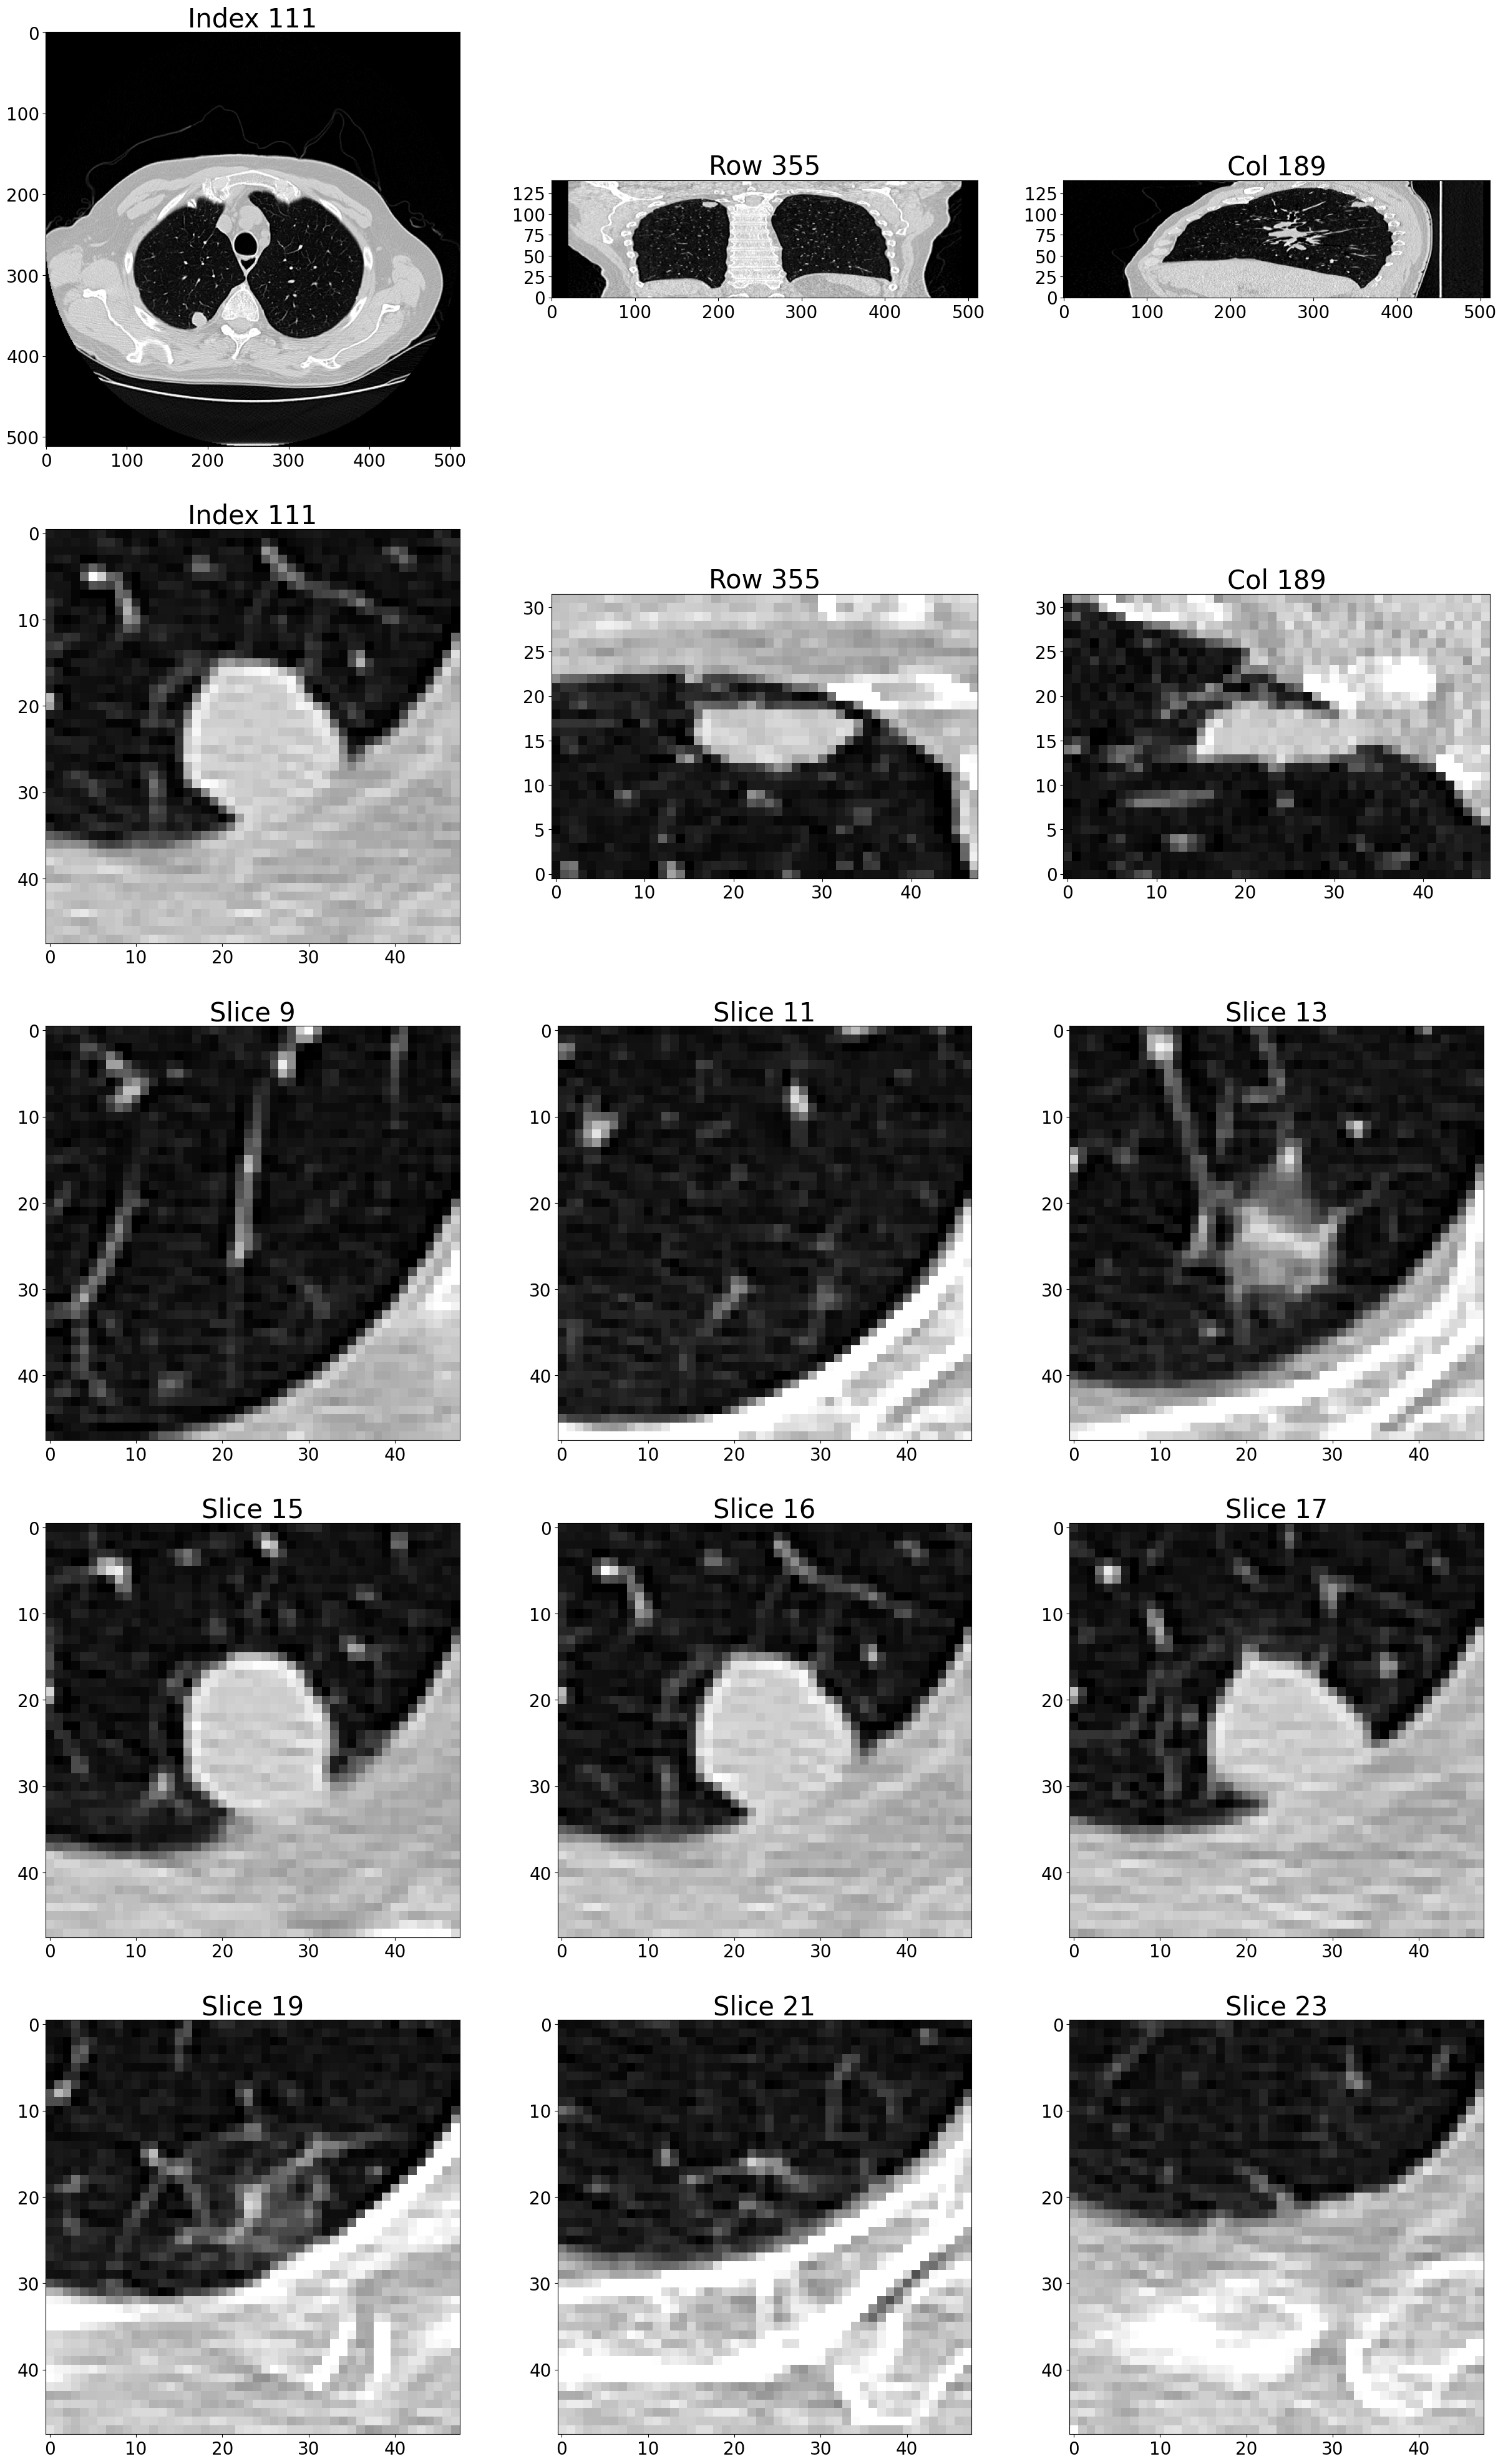

In [6]:
visualizations.show_positive_candidate()

# Malignant Cutouts Dataset